In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense
from keras.optimizers import Adam
import zipfile
with zipfile.ZipFile('/content/training-validation-3.zip', 'r') as zip_ref:
    zip_ref.extractall('data_folder')
# Load data from all subfolders of given dataset
folder_paths = ['data_folder/sub01', 'data_folder/sub02', 'data_folder/sub03', 'data_folder/sub05']
all_data = []
for folder_path in folder_paths:
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            filepath = os.path.join(folder_path, file)
            all_data.append(pd.read_csv(filepath, header=None))
# Concatenating the data from all subfolders
if all_data:
    all_data = pd.concat(all_data)
else:
    raise ValueError("No data files found.")
# Splitting the data into features and labels
X = all_data.iloc[:, :-1].values
y = all_data.iloc[:, -1].values

In [2]:
import os
import shutil
import glob
def move_csv_files(source_folders, destination_folder):
    os.makedirs(destination_folder, exist_ok=True)
    for source_folder in source_folders:
        csv_files = glob.glob(os.path.join(source_folder, '*.csv'))
        for csv_file in csv_files:
            file_name = os.path.basename(csv_file)
            destination_file_path = os.path.join(destination_folder, file_name)
            shutil.move(csv_file, destination_file_path)
source_folders = ["/content/data_folder/sub01", "/content/data_folder/sub02", "/content/data_folder/sub03","/content/data_folder/sub05"]  # List of source folders
destination_folder = "/content/data_folder/moved_files"
move_csv_files(source_folders, destination_folder)


In [3]:
import os
def count_files(folder_path):
    num_files = 0
    for _, _, files in os.walk(folder_path):
        num_files += len(files)
    return num_files
folder_path = "/content/data_folder/moved_files"
num_files = count_files(folder_path)
print("Number of files in the folder:", num_files)

Number of files in the folder: 400


In [4]:
import os
import pandas as pd
def delete_first_column(folder_path):
    files = os.listdir(folder_path)
    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        if file_name.endswith('.csv'):
            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)
            # Drop the first column
            df = df.iloc[:, 1:]
            df.to_csv(file_path, index=False)
folder_path = "/content/data_folder/moved_files"
delete_first_column(folder_path)

In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(folder_path, test_size=0.2, random_state=None):
    file_paths = []
    train_x = []
    train_y = []

    max_seq_length = 0

    files = os.listdir(folder_path)

    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        file_paths.append(file_path)
        # pre-processing techniques
        data = pd.read_csv(file_path, header=None)
        data = data.dropna() # pre-processing Technique-1 : cleaning Data
        data.dropna(how='all', inplace=True)
        data = data.apply(pd.to_numeric, errors='coerce')

        column_means = data.mean()
        data.fillna(column_means, inplace=True)# pre-processing Technique-2 : imputing Nan values with column mean
        if data.isnull().values.any():
            data.fillna(0, inplace=True)
            data.fillna(1, inplace=True)

        x = data.iloc[:, :3].values # pre-processing Technique-3 : Selecting Features
        y = data.iloc[0, 3]
        if np.isnan(y):
            print(f"Warning: NaN value detected for output label in {file_name}. Skipping this sample.")
            continue

        train_x.append(x)
        train_y.append(int(y))

        if len(x) > max_seq_length:
            max_seq_length = len(x)

    # Convert lists to numpy arrays
    train_x = np.array(train_x)
    train_y = np.array(train_y).reshape(-1, 1)
    num_features = 3
    train_x_padded = np.zeros((train_x.shape[0], max_seq_length, num_features))# pre-processing Technique-4: Sequence Padding
    train_x_padded[:, :train_x.shape[1], :] = train_x

    # Perform train-validation split
    train_x_split, valid_x_split, train_y_split, valid_y_split = train_test_split(train_x_padded, train_y, test_size=test_size, random_state=random_state)
    return train_x_split, valid_x_split, train_y_split, valid_y_split
folder_path = "/content/data_folder/moved_files"
train_x, valid_x, train_y, valid_y = load_data(folder_path, test_size=0.2, random_state=42)

print("Shape of train_x:", train_x.shape)
print("Shape of valid_x:", valid_x.shape)
print("Shape of train_y:", train_y.shape)
print("Shape of valid_y:", valid_y.shape)


Shape of train_x: (320, 31, 3)
Shape of valid_x: (80, 31, 3)
Shape of train_y: (320, 1)
Shape of valid_y: (80, 1)


In [6]:
train_y = train_y.reshape(-1, 1)  # Reshape labels to have a single column (32, 1)
valid_y = valid_y.reshape(-1, 1)  # Reshape labels to have a single column (80, 1)


In [26]:
pip install tensorflow-addons


In [76]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTMCell, RNN, Dropout, Dense, BatchNormalization
from tensorflow.keras import regularizers

# functions of LSTM aND LSTM with peephole LSTM models
def create_rnn_model_lstm(input_shape, num_classes):
    model = Sequential([
        RNN(LSTMCell(128, kernel_regularizer=regularizers.l2(0.0001), recurrent_regularizer=regularizers.l2(0.001)), return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        RNN(LSTMCell(128, kernel_regularizer=regularizers.l2(0.0001), recurrent_regularizer=regularizers.l2(0.001)), return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),
        RNN(LSTMCell(128, kernel_regularizer=regularizers.l2(0.0001), recurrent_regularizer=regularizers.l2(0.001)), return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),
        RNN(LSTMCell(128, kernel_regularizer=regularizers.l2(0.0001), recurrent_regularizer=regularizers.l2(0.001)), return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),
        RNN(LSTMCell(128, kernel_regularizer=regularizers.l2(0.0001), recurrent_regularizer=regularizers.l2(0.001))),
        BatchNormalization(),
        Dropout(0.2),
        Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        Dropout(0.2),
        Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

def create_rnn_model_peephole_lstm(input_shape, num_classes):
    model = Sequential([
        RNN(tfa.rnn.PeepholeLSTMCell(128, kernel_regularizer=regularizers.l2(0.0001), recurrent_regularizer=regularizers.l2(0.001)), return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        RNN(tfa.rnn.PeepholeLSTMCell(128, kernel_regularizer=regularizers.l2(0.0001), recurrent_regularizer=regularizers.l2(0.001)), return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),
        RNN(tfa.rnn.PeepholeLSTMCell(128, kernel_regularizer=regularizers.l2(0.0001), recurrent_regularizer=regularizers.l2(0.001)), return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),
        RNN(tfa.rnn.PeepholeLSTMCell(128, kernel_regularizer=regularizers.l2(0.0001), recurrent_regularizer=regularizers.l2(0.001)), return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),
        RNN(tfa.rnn.PeepholeLSTMCell(128, kernel_regularizer=regularizers.l2(0.0001), recurrent_regularizer=regularizers.l2(0.001))),
        BatchNormalization(),
        Dropout(0.2),
        Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        Dropout(0.2),
        Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Adjusting the input_shape and num_classes based on the data
input_shape = (train_x.shape[1], train_x.shape[2])
num_classes = 3  # Assuming you have 3 classes for classification



**Create, compile, Train both the models**

In [77]:
# Create both models
lstm_model = create_rnn_model_lstm(input_shape, num_classes)
peephole_lstm_model = create_rnn_model_peephole_lstm(input_shape, num_classes)

In [78]:
lstm_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
peephole_lstm_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

lstm_model_history = lstm_model.fit(train_x, train_y, epochs=40, batch_size=32, validation_data=(valid_x, valid_y))
peephole_lstm_model_history = peephole_lstm_model.fit(train_x, train_y, epochs=40, batch_size=32,  validation_data=(valid_x, valid_y))


Epoch 1/40
10/10 [==============================] - 41s 406ms/step - loss: 1.7372 - accuracy: 0.5719 - val_loss: 1.8074 - val_accuracy: 0.6500
Epoch 2/40
10/10 [==============================] - 4s 437ms/step - loss: 1.4282 - accuracy: 0.6844 - val_loss: 1.7183 - val_accuracy: 0.6875
Epoch 3/40
10/10 [==============================] - 3s 293ms/step - loss: 1.4497 - accuracy: 0.7063 - val_loss: 1.6246 - val_accuracy: 0.6625
Epoch 4/40
10/10 [==============================] - 3s 292ms/step - loss: 1.3471 - accuracy: 0.7344 - val_loss: 1.6509 - val_accuracy: 0.6625
Epoch 5/40
10/10 [==============================] - 3s 290ms/step - loss: 1.3007 - accuracy: 0.6938 - val_loss: 1.5663 - val_accuracy: 0.7000
Epoch 6/40
10/10 [==============================] - 4s 445ms/step - loss: 1.2318 - accuracy: 0.7531 - val_loss: 1.4798 - val_accuracy: 0.6625
Epoch 7/40
10/10 [==============================] - 3s 299ms/step - loss: 1.1873 - accuracy: 0.7469 - val_loss: 1.3876 - val_accuracy: 0.6875
Epoch

In [79]:
lstm_train_loss = lstm_model_history.history['loss']
lstm_valid_loss = lstm_model_history.history['val_loss']
lstm_train_acc = lstm_model_history.history['accuracy']
lstm_valid_acc = lstm_model_history.history['val_accuracy']

peephole_lstm_train_loss = peephole_lstm_model_history.history['loss']
peephole_lstm_valid_loss = peephole_lstm_model_history.history['val_loss']
peephole_lstm_train_acc = peephole_lstm_model_history.history['accuracy']
peephole_lstm_valid_acc = peephole_lstm_model_history.history['val_accuracy']

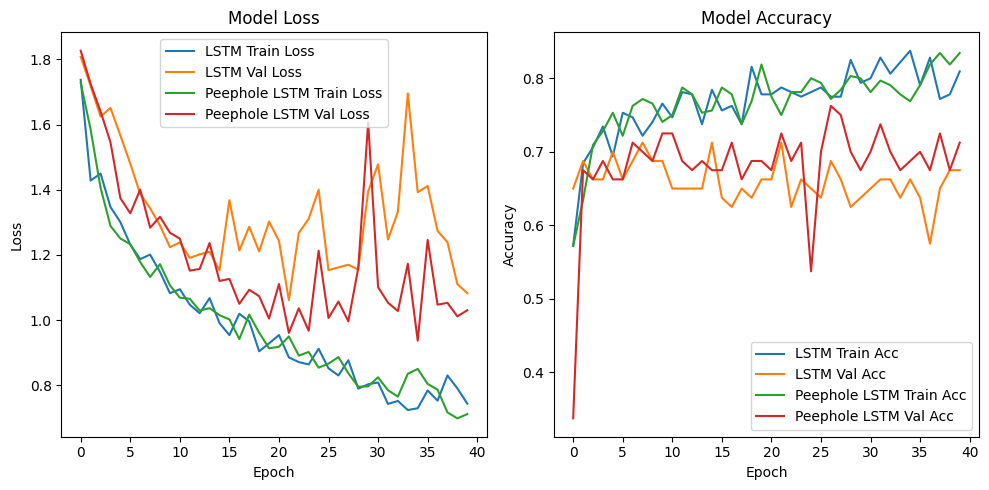

In [80]:
import matplotlib.pyplot as plt
epochs = range(len(lstm_train_loss))  # Assuming same number of epochs for both models

plt.figure(figsize=(10, 5))

#Creating Loss plot
plt.subplot(121)
plt.plot(epochs, lstm_train_loss, label='LSTM Train Loss')
plt.plot(epochs, lstm_valid_loss, label='LSTM Val Loss')
plt.plot(epochs, peephole_lstm_train_loss, label='Peephole LSTM Train Loss')
plt.plot(epochs, peephole_lstm_valid_loss, label='Peephole LSTM Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#Curve of Accuracy plot
plt.subplot(122)
plt.plot(epochs, lstm_train_acc, label='LSTM Train Acc')
plt.plot(epochs, lstm_valid_acc, label='LSTM Val Acc')
plt.plot(epochs, peephole_lstm_train_acc, label='Peephole LSTM Train Acc')
plt.plot(epochs, peephole_lstm_valid_acc, label='Peephole LSTM Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

**Comparision :** While the original LSTM (0.675) and the LSTM with peephole connections obtained significantly higher final validation accuracy (0.725), both models demonstrated a general decrease in loss throughout training epochs.

In [83]:
lstm_model.save("lstm_model.h5")
peephole_lstm_model.save("peephole_lstm_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Testing script**

In [82]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTMCell, RNN, Dropout, Dense, BatchNormalization
import contextlib
# Load the models
lstm_model = load_model("lstm_model.h5", custom_objects={'PeepholeLSTMCell': tfa.rnn.PeepholeLSTMCell})
peephole_lstm_model = load_model("peephole_lstm_model.h5", custom_objects={'PeepholeLSTMCell': tfa.rnn.PeepholeLSTMCell})
def preprocess_and_predict_lstm(model, file_path):
    data = pd.read_csv(file_path, header=None)
    features = data.iloc[:, 1:4].apply(pd.to_numeric, errors='coerce')
    features = features.fillna(features.mean()).fillna(0)
    features = features.values.astype(np.float32)
    features = np.expand_dims(features, axis=2)
    features = np.expand_dims(features, axis=0)
    with open(os.devnull, 'w') as devnull:
        with contextlib.redirect_stdout(devnull):
            predictions = model.predict(features)
    predicted_label = np.argmax(predictions)
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_label, predicted_class[0]
def preprocess_and_predict_peephole_lstm(model, file_path):
    data = pd.read_csv(file_path, header=None)
    features = data.iloc[:, 1:4].apply(pd.to_numeric, errors='coerce')
    features = features.fillna(features.mean()).fillna(0)
    features = features.values.astype(np.float32)
    features = np.expand_dims(features, axis=2)
    features = np.expand_dims(features, axis=0)
    with open(os.devnull, 'w') as devnull:
        with contextlib.redirect_stdout(devnull):
            predictions = model.predict(features)
    predicted_label = np.argmax(predictions)
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_label, predicted_class[0]

# Upload the test folder containing multiple CSV files
test_folder = "/content/Test_dataset"

#assuming test files are in a test dataset folder
test_files = [f for f in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder, f))]

predicted_labels_lstm = []
predicted_classes_lstm = []
actual_labels_lstm = []

predicted_labels_peephole_lstm = []
predicted_classes_peephole_lstm = []
actual_labels_peephole_lstm = []

# Process each file in the test folder
for file_name in test_files:
    file_path = os.path.join(test_folder, file_name)

    # For LSTM model
    predicted_label_lstm, predicted_class_lstm = preprocess_and_predict_lstm(lstm_model, file_path)
    predicted_labels_lstm.append(predicted_label_lstm)
    predicted_classes_lstm.append(predicted_class_lstm)

    # For Peephole LSTM model
    predicted_label_peephole_lstm, predicted_class_peephole_lstm = preprocess_and_predict_peephole_lstm(peephole_lstm_model, file_path)
    predicted_labels_peephole_lstm.append(predicted_label_peephole_lstm)
    predicted_classes_peephole_lstm.append(predicted_class_peephole_lstm)

    # Actual label
    actual_label = pd.read_csv(file_path, header=None).iloc[0, 4]
    actual_labels_lstm.append(actual_label)
    actual_labels_peephole_lstm.append(actual_label)

# Calculate accuracy
num_correct_lstm = sum(pred == actual for pred, actual in zip(predicted_labels_lstm, actual_labels_lstm))
accuracy_lstm = (num_correct_lstm / len(test_files)) * 100
print(f"Overall Accuracy for LSTM model: {accuracy_lstm:.2f}%")
num_correct_peephole_lstm = sum(pred == actual for pred, actual in zip(predicted_labels_peephole_lstm, actual_labels_peephole_lstm))
accuracy_peephole_lstm = (num_correct_peephole_lstm / len(test_files)) * 100
print(f"Overall Accuracy for Peephole LSTM model: {accuracy_peephole_lstm:.2f}%")

# Printing predicted classes for each file
print("\nPredicted Classes for LSTM model:")
for file_name, predicted_class in zip(test_files, predicted_classes_lstm):
    print(f"File: {file_name}, Predicted Class: {predicted_class}")

print("\nPredicted Classes for Peephole LSTM model:")
for file_name, predicted_class in zip(test_files, predicted_classes_peephole_lstm):
    print(f"File: {file_name}, Predicted Class: {predicted_class}")


Overall Accuracy for LSTM model: 50.87%
Overall Accuracy for Peephole LSTM model: 68.86%

Predicted Classes for LSTM model:
File: Vd01_Sg_003_VS_Set3.csv, Predicted Class: 0
File: Vd02_Sg_059_VS_Set2.csv, Predicted Class: 0
File: Vd01_Sg_051_VS_Set2.csv, Predicted Class: 1
File: Vd02_Sg_080_VS_Set2.csv, Predicted Class: 0
File: Vd01_Sg_026_VS_Set2.csv, Predicted Class: 1
File: Vd01_Sg_077_VS_Set2.csv, Predicted Class: 0
File: Vd01_Sg_016_VS_Set2.csv, Predicted Class: 0
File: Vd01_Sg_047_VS_Set2.csv, Predicted Class: 1
File: Vd02_Sg_067_VS_Set2.csv, Predicted Class: 0
File: Vd02_Sg_054_VS_Set1.csv, Predicted Class: 0
File: Vd01_Sg_027_VS_Set1.csv, Predicted Class: 0
File: Vd02_Sg_086_VS_Set2.csv, Predicted Class: 0
File: Vd02_Sg_050_VS_Set2.csv, Predicted Class: 0
File: Vd02_Sg_052_VS_Set1.csv, Predicted Class: 0
File: Vd01_Sg_108_VS_Set2.csv, Predicted Class: 0
File: Vd02_Sg_097_VS_Set2.csv, Predicted Class: 0
File: Vd01_Sg_002_VS_Set2.csv, Predicted Class: 0
File: Vd02_Sg_121_VS_Set2.